# One-dimensional glitch example

This notebook derives the equations for a one-dimensional glitch example.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

from scipy.optimize import newton
from sympy import latex, exp, sin, cos, re, im
from sympy import I as i
from ipywidgets import interact
from collections import namedtuple
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


In [2]:
%%tikz
\def\labelshift{(0, -0.4)}%

\node[label={[anchor=base,shift=\labelshift]below:0}] (A) at (0, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$L$}] (B) at (10, 0) {};

\filldraw (A) circle (2pt) -- (B) circle (2pt);

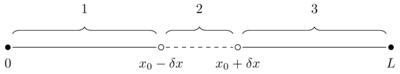

In [584]:
%%tikz -x \usetikzlibrary{decorations.pathreplacing}
\def\labelshift{(0, -0.4)}%
\def\regionshift{(0, 1)}%
\node[label={[anchor=base,shift=\labelshift]below:0}] (A) at (0, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$x_0-\delta x$}] (B) at (4, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$x_0+\delta x$}] (C) at (6, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$L$}] (D) at (10, 0) {};

\fill (A) circle (2pt) (D) circle (2pt);
\draw (B) circle (2pt) (C) circle (2pt);
\draw (A) -- (B) (C) -- (D);
\draw[dashed] (B) -- (C);

\draw[decorate,decoration={brace,amplitude=5pt,raise=10pt}] (A) -- (B) node[midway,shift=\regionshift]{1};
\draw[decorate,decoration={brace,amplitude=5pt,raise=10pt}] (B) -- (C) node[midway,shift=\regionshift]{2};
\draw[decorate,decoration={brace,amplitude=5pt,raise=10pt}] (C) -- (D) node[midway,shift=\regionshift]{3};

In [585]:
%%tikz -x \usetikzlibrary{decorations.pathreplacing} --format pdf --save ../figures/glitch-1d-example-diagram.pdf
\def\labelshift{(0, -0.4)}%
\def\regionshift{(0, 1)}%
\node[label={[anchor=base,shift=\labelshift]below:0}] (A) at (0, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$x_0-\delta x$}] (B) at (4, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$x_0+\delta x$}] (C) at (6, 0) {};
\node[label={[anchor=base,shift=\labelshift]below:$L$}] (D) at (10, 0) {};

\fill (A) circle (2pt) (D) circle (2pt);
\draw (B) circle (2pt) (C) circle (2pt);
\draw (A) -- (B) (C) -- (D);
\draw[dashed] (B) -- (C);

\draw[decorate,decoration={brace,amplitude=5pt,raise=10pt}] (A) -- (B) node[midway,shift=\regionshift]{1};
\draw[decorate,decoration={brace,amplitude=5pt,raise=10pt}] (B) -- (C) node[midway,shift=\regionshift]{2};
\draw[decorate,decoration={brace,amplitude=5pt,raise=10pt}] (C) -- (D) node[midway,shift=\regionshift]{3};

In [219]:
Complex = namedtuple('Complex', ['real', 'imag'])

In [220]:
# Variables in the system
omega, k, x, t = sympy.symbols("omega, k, x, t", real=True)

# Constants of the system
c, x0, L = sympy.symbols("c, x_0, L", real=True)

# Perturbations in x, k, and c
dx, dk, dc = sympy.symbols("delta_x, delta_k, delta_c", real=True)

In [221]:
A, B, C, D = coeff = sympy.symbols("A, B, C, D", complex=True)

coeff_mag = sympy.symbols(", ".join([f"r_{key}" for key in coeff]), real=True)
coeff_arg = sympy.symbols(", ".join([f"phi_{key}" for key in coeff]), real=True)

r = dict(zip(coeff, coeff_mag))
phi = dict(zip(coeff, coeff_arg))

In [222]:
xi1_left = exp(i * (omega * t - k * x)) + A * exp(i * (omega * t + k * x))
xi2_left = B * exp(i * (omega * t - (k + dk) * x)) + C * exp(i * (omega * t + (k + dk) * x))
xi3_left = D * exp(i * (omega * t - k * x))

In [223]:
xi = {j: sympy.Function(f'xi_{j}')(x, t) for j in range(1,4)}

Consider a wave travelling from left to right in the above system.

{{xi[1]}} $\,=\,$ {{xi1_left}}

{{xi[2]}} $\,=\,$ {{xi2_left}}

{{xi[3]}} $\,=\,$ {{xi3_left}}

Let's define the boundary conditions to ensure continuity,

{{xi[1].subs(x, x0)}} $\,=\,$ {{xi[2].subs(x, x0)}}

{{xi[2].subs(x, x0+dx)}} $\,=\,$ {{xi[3].subs(x, x0+dx)}}

{{xi[1].diff(x).subs(x, x0)}} $\,=\,$ {{xi[2].diff(x).subs(x, x0)}}

{{xi[2].diff(x).subs(x, x0+dx)}} $\,=\,$ {{xi[3].diff(x).subs(x, x0+dx)}}

In [224]:
# boundary_conditions = [
#     (xi1_left - xi2_left).subs(x, x0),
#     (xi2_left - xi3_left).subs(x, x0+dx),
#     (xi1_left.diff(x) - xi2_left.diff(x)).subs(x, x0),
#     (xi2_left.diff(x) - xi3_left.diff(x)).subs(x, x0+dx),
# ]

boundary_conditions = [
    (xi1_left - xi2_left).subs(x, x0-dx),
    (xi2_left - xi3_left).subs(x, x0+dx),
    (xi1_left.diff(x) - xi2_left.diff(x)).subs(x, x0-dx),
    (xi2_left.diff(x) - xi3_left.diff(x)).subs(x, x0+dx),
]

# kp, a, b = sympy.symbols("k', a, b")

# subs = {k+dk: kp, x0: a, x0+dx: b}

# boundary_conditions = [
#     (xi1_left - xi2_left).subs(subs).subs(x, x0),
#     (xi2_left - xi3_left).subs(subs).subs(x, x0+dx),
#     (xi1_left.diff(x) - xi2_left.diff(x)).subs(subs).subs(x, x0),
#     (xi2_left.diff(x) - xi3_left.diff(x)).subs(subs).subs(x, x0+dx),
# ]

In [225]:
sol = sympy.solve(boundary_conditions, coeff)

In [349]:
num, den = sympy.fraction(sol[A].simplify())
den

delta_k**2*exp(4*I*delta_k*delta_x + 4*I*delta_x*k) - delta_k**2 + 4*delta_k*k*exp(4*I*delta_k*delta_x + 4*I*delta_x*k) + 4*k**2*exp(4*I*delta_k*delta_x + 4*I*delta_x*k)

In [227]:
fac = exp(2*i*k*x0)

We want to take out the factor of {{fac}}

In [230]:
alpha = den #/ fac
alpha

delta_k**2*exp(4*I*delta_k*delta_x + 4*I*delta_x*k) - delta_k**2 + 4*delta_k*k*exp(4*I*delta_k*delta_x + 4*I*delta_x*k) + 4*k**2*exp(4*I*delta_k*delta_x + 4*I*delta_x*k)

In [235]:
# alpha_factorised = (dk + 2*k)**2 * exp(2*i*dx*(k+dk)) - dk**2
alpha_factorised = (dk + 2*k)**2 * exp(4*i*dx*(k+dk)) - dk**2

alpha_factorised

-delta_k**2 + (delta_k + 2*k)**2*exp(4*I*delta_x*(delta_k + k))

In [236]:
alpha.expand() == alpha_factorised.expand()

True

In [255]:
# (sol[A]*alpha).factor()
(sol[A]*alpha).simplify()

delta_k*(-delta_k*exp(4*I*delta_x*(delta_k + k)) + delta_k - 2*k*exp(4*I*delta_x*(delta_k + k)) + 2*k)*exp(2*I*k*(delta_x - x_0))

In [252]:
(sol[B]*alpha).factor()

2*k*(delta_k + 2*k)*exp(3*I*delta_k*delta_x)*exp(I*delta_k*x_0)*exp(4*I*delta_x*k)

In [253]:
(sol[C]*alpha).factor()

2*delta_k*k*exp(I*delta_k*delta_x)*exp(-I*delta_k*x_0)*exp(2*I*delta_x*k)*exp(-2*I*k*x_0)

In [254]:
(sol[D]*alpha).factor()

4*k*(delta_k + k)*exp(2*I*delta_k*delta_x)*exp(4*I*delta_x*k)

In [256]:
f_xi = sympy.Function('xi')

We now must superpose the right-travelling wave, {{-f_xi(-k, -dk)}} and impose the boundary conditions at $x=0$ and $x=L$

Since the coefficients are a function of {{k}} and {{dk}}, we shall get the right-travellling coefficients first. As it happens, these yield the complex coefficients. To validate this...

In [257]:
# Map wavenumber from left- to right-travelling wave
right_mapping = {
    k: -k, 
    dk: -dk,
}

Verify that the coefficients for the right-travelling wave are the complex conjugates of those for the left-travelling wave

In [258]:
all(sol[key].subs(right_mapping) == sol[key].conjugate() for key in coeff)

True

In [259]:
# Map complex coefficients to their conjugate (a + i*b to a - i*b)
# Worth checking that it makes sense if you swap k for -k in coeffs?
right_mapping.update(
    {key: sympy.conjugate(key) for key in coeff}
)

xi1 = xi1_left - xi1_left.subs(right_mapping)
xi2 = xi2_left - xi2_left.subs(right_mapping)
xi3 = xi3_left - xi3_left.subs(right_mapping)

Now our wavefunctions look like this,

{{xi[1]}} $\,=\,$ {{xi1}}

{{xi[2]}} $\,=\,$ {{xi2}}

{{xi[3]}} $\,=\,$ {{xi3}}

Let's substitute Euler's formula,

$$X = r_X e^{i \phi_X}$$

for each coefficient $X$

In [260]:
euler_mapping = {key: r[key] * exp(i * phi[key]) for key in coeff}

Now, we need to impose the boundary conditions. Starting with $x=0$, let's look at the real part of {{xi[1]}}.

In [261]:
sympy.re(xi1.subs(euler_mapping)).simplify()

2*(-r_A*sin(k*x + phi_A) + sin(k*x))*sin(omega*t)

In [262]:
Xi1 = Complex(*xi1.subs(euler_mapping).as_real_imag())
Xi2 = Complex(*xi2.subs(euler_mapping).as_real_imag())
Xi3 = Complex(*xi3.subs(euler_mapping).as_real_imag())

If we substitute $x=0$ we do not get a displacement of 0, we instead get,

{{xi[1].subs(x, 0)}} $\,=\,$ {{Xi1.real.subs(x, 0).simplify()}} $\,\neq 0$

So we need to introduce a displacement $\epsilon$ which corrects for this phase change.

$$x \rightarrow x + \epsilon$$

In [263]:
epsilon = sympy.symbols('epsilon', real=True)
phase_mapping = {x: x + epsilon}

Xi1 = Complex(*xi1.subs(euler_mapping).subs(phase_mapping).as_real_imag())
Xi2 = Complex(*xi2.subs(euler_mapping).subs(phase_mapping).as_real_imag())
Xi3 = Complex(*xi3.subs(euler_mapping).subs(phase_mapping).as_real_imag())

In [264]:
Xi = {key+1: value.real.rewrite(cos).trigsimp(method='fu').factor() for key, value in enumerate([Xi1, Xi2, Xi3])}

Now we get some nice solutions,

{{xi[1]}} $\,=\,$ {{Xi[1]}}

{{xi[2]}} $\,=\,$ {{Xi[2]}}

{{xi[3]}} $\,=\,$ {{Xi[3]}}

Let's solve for {{epsilon}} at $x=0$. We'll help sympy out by dividing by {{sin(k*epsilon)}}.

In [265]:
f = (sympy.expand_trig(Xi[1].subs(x, 0)) / sin(k * epsilon)).trigsimp()
f

-2*(r_A*sin(phi_A)/tan(epsilon*k) + r_A*cos(phi_A) - 1)*sin(omega*t)

In [266]:
phase_sol, = sympy.solve(f, epsilon, dict=True)
phase_sol[epsilon]

-atan(r_A*sin(phi_A)/(r_A*cos(phi_A) - 1))/k

Which may be written in terms of real and imaginary components of the coefficients.

In [267]:
euler_trig = {}
euler_trig.update({r[key] * cos(phi[key]): sympy.re(key) for key in coeff})
euler_trig.update({r[key] * sin(phi[key]): sympy.im(key) for key in coeff})

phase_sol[epsilon].subs(euler_trig)

-atan(im(A)/(re(A) - 1))/k

Now we can take the boundary at $x=L$ to solve for {{omega}}.

In [268]:
g = (Xi[3].subs(x, L))
g

2*r_D*sin(omega*t)*sin(L*k + epsilon*k - phi_D)

Easy to sub out Re(X) and Im(X) for rX cos(phiX) and rX sin(phiX) for coeff X.

In [269]:
h = sympy.expand_trig(g).expand().subs(euler_trig).trigsimp() / 2/ sin(omega * t)
h

sin(k*(L + epsilon))*re(D) - cos(k*(L + epsilon))*im(D)

In [270]:
wavenum_mapping = {
    k: omega / c,
    dk: - dc * omega / c**2,
}

In [271]:
upper_bc = h.subs(
    epsilon, 
    phase_sol[epsilon].subs(euler_trig)
).subs(
    sol  # coefficients solution
).subs(
    wavenum_mapping
)

In [272]:
upper_numpy = sympy.lambdify((omega, c, dc, x0, dx, L), upper_bc, 'numpy')

In [273]:
n = np.arange(1, 51)
sound_speed = 1.0
length = 1.0
omega0 = sound_speed * n * np.pi / length  # uniform medium case
omega_sol = newton(upper_numpy, omega0, args=(sound_speed, 0.05, 0.955, 0.015, length))

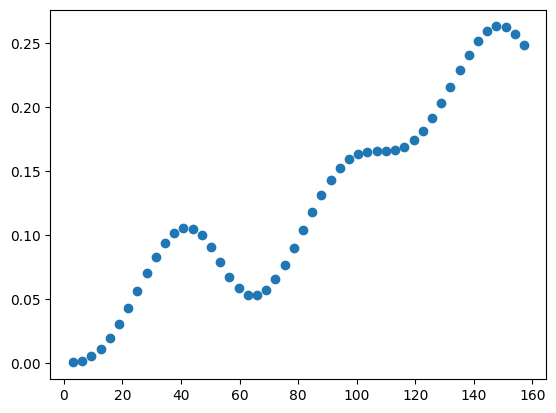

In [274]:
%matplotlib inline

plt.plot(omega0, omega_sol-omega0, 'o')

In [275]:
Xi_total = sum(Xi.values())
Xi_total

2*r_D*sin(omega*t)*sin(epsilon*k + k*x - phi_D) - 2*(r_A*sin(epsilon*k + k*x + phi_A) - sin(epsilon*k + k*x))*sin(omega*t) + 2*(r_B*sin(delta_k*epsilon + delta_k*x + epsilon*k + k*x - phi_B) - r_C*sin(delta_k*epsilon + delta_k*x + epsilon*k + k*x + phi_C))*sin(omega*t)

In [276]:
Xi_total = sympy.expand_trig(Xi_total).expand().subs(euler_trig).trigsimp()

In [277]:
Xi_total

sin(epsilon*k + k*x - omega*t)*im(A) + sin(epsilon*k + k*x - omega*t)*im(D) - sin(epsilon*k + k*x + omega*t)*im(A) - sin(epsilon*k + k*x + omega*t)*im(D) + sin(delta_k*epsilon + delta_k*x + epsilon*k + k*x - omega*t)*im(B) + sin(delta_k*epsilon + delta_k*x + epsilon*k + k*x - omega*t)*im(C) - sin(delta_k*epsilon + delta_k*x + epsilon*k + k*x + omega*t)*im(B) - sin(delta_k*epsilon + delta_k*x + epsilon*k + k*x + omega*t)*im(C) - cos(epsilon*k + k*x - omega*t)*re(A) + cos(epsilon*k + k*x - omega*t)*re(D) + cos(epsilon*k + k*x - omega*t) + cos(epsilon*k + k*x + omega*t)*re(A) - cos(epsilon*k + k*x + omega*t)*re(D) - cos(epsilon*k + k*x + omega*t) + cos(delta_k*epsilon + delta_k*x + epsilon*k + k*x - omega*t)*re(B) - cos(delta_k*epsilon + delta_k*x + epsilon*k + k*x - omega*t)*re(C) - cos(delta_k*epsilon + delta_k*x + epsilon*k + k*x + omega*t)*re(B) + cos(delta_k*epsilon + delta_k*x + epsilon*k + k*x + omega*t)*re(C)

In [278]:
Xi_total = Xi_total.subs(
    epsilon, phase_sol[epsilon].subs(euler_trig)
).subs(
    sol
).subs(
    wavenum_mapping
)

In [279]:
Xi_numpy = sympy.lambdify((x, t, omega, c, dc, x0, dx, L), Xi_total, "numpy")

In [280]:
def find_omega(loc, width, delta_sound, omega0=omega0):
    args = (sound_speed, delta_sound, loc, min(width, length-loc), length)
    res = newton(upper_numpy, omega0, args=args, full_output=True)
    return res.root

def plot_omega(loc, width, delta_sound, ax=None, offset=0.0, fac=0, omega0=omega0, **kwargs):
    omega_sol = find_omega(loc, width, delta_sound, omega0=omega0)
    delta_omega = omega_sol - omega0
    
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(omega0, (delta_omega+offset)*10**fac, **kwargs)
    return ax

def find_xi(x, t, omega, loc, width, delta_sound):
    args = (x, t, omega, sound_speed, delta_sound, loc, min(width, length-loc), length)
    return Xi_numpy(*args)

<IPython.core.display.Javascript object>


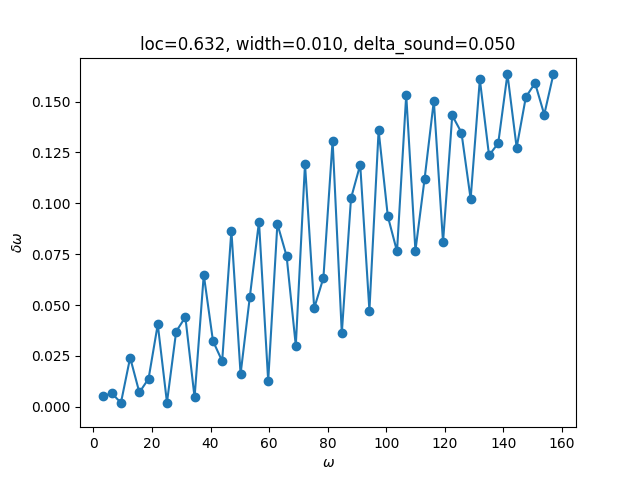

interactive(children=(FloatSlider(value=0.5, description='loc', max=1.0, step=0.001), FloatSlider(value=0.01, …

In [536]:
%matplotlib notebook
fig, ax = plt.subplots()

# @interact(loc=(0.7, 1, 0.001), width=(0, 0.1, 0.001), delta_sound=(-0.05, 0.05, 0.001))
@interact(loc=(0.0, 1.0, 0.001), width=(0, 0.1, 0.001), delta_sound=(-0.05, 0.05, 0.001))
def update(loc=0.5, width=0.01, delta_sound=0.05):
    
    ax.clear()
    plot_omega(loc, width, delta_sound, ax=ax, marker='o')
    ax.set_title(f"loc={loc:.3f}, width={width:.3f}, delta_sound={delta_sound:.3f}")
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$\delta\omega$")
    ylim = tuple(map(lambda x: x/abs(x) * max(abs(x), 0.01), ax.get_ylim()))
    ax.set_ylim(ylim)

In [285]:
args = (0.9, 0.02, 0.03)
x_pos = np.linspace(args[0]-args[1], args[0]+args[1], 201)
omega_sol = find_omega(*args)
xi_sol = find_xi(x_pos[:, None], np.pi/4, omega_sol, *args)

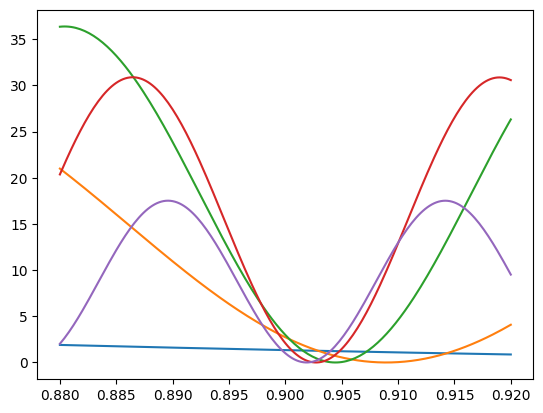

In [286]:
%matplotlib inline
fig, ax = plt.subplots()

for wave in (xi_sol[:, ::10]**2).T:
    ax.plot(x_pos, wave)

<IPython.core.display.Javascript object>


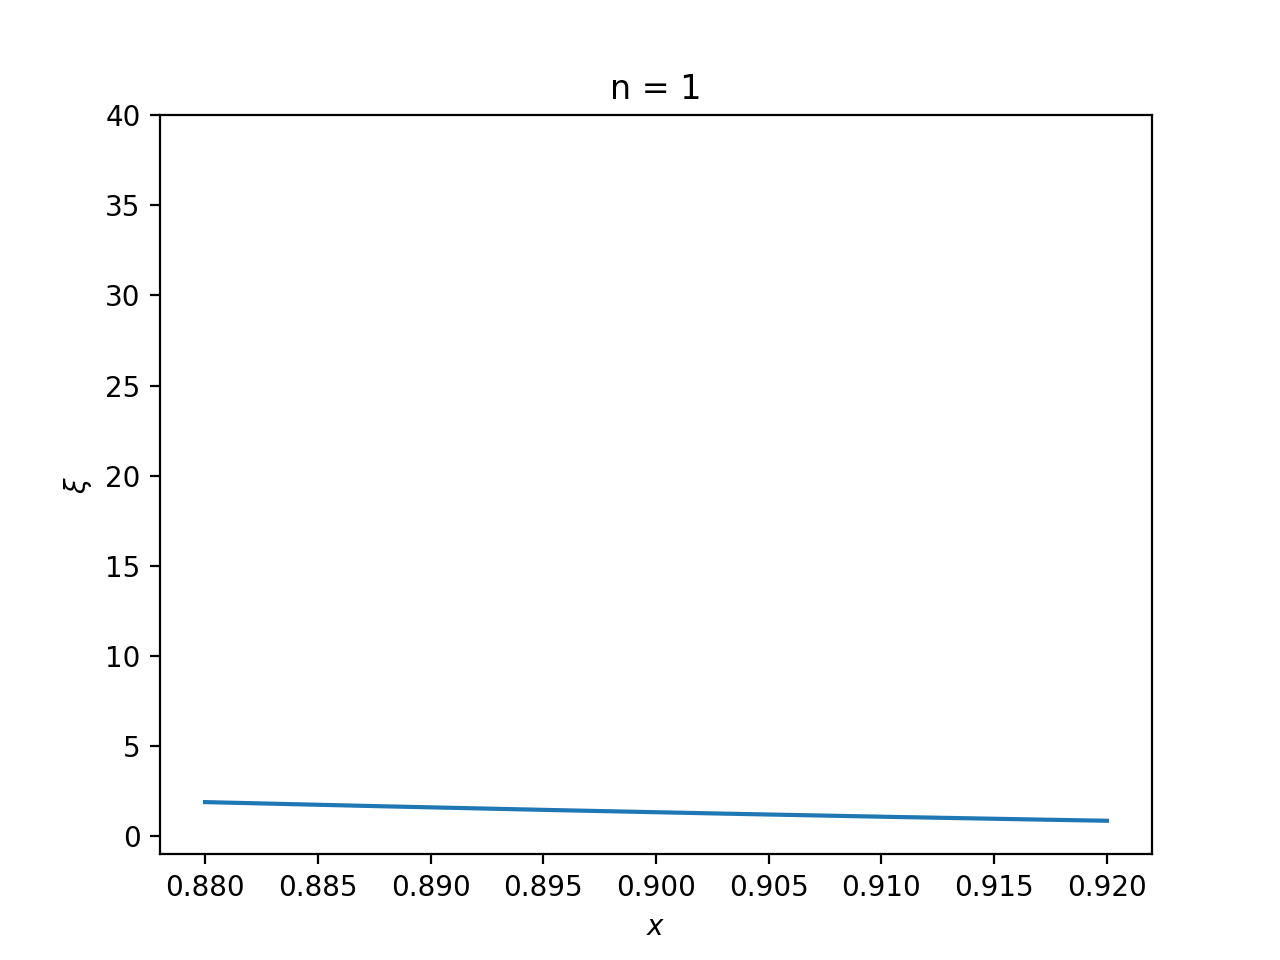

interactive(children=(IntSlider(value=1, description='n', max=50, min=1), Output()), _dom_classes=('widget-int…

In [287]:
%matplotlib notebook
fig, ax = plt.subplots()

@interact(n=(1, 50, 1))
def update(n=1):
    
    xi_sol = find_xi(x_pos, np.pi/4, omega_sol[n-1], *args)
    ax.clear()
    ax.plot(x_pos, xi_sol**2)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$\xi$")
    ax.set_title(f"n = {n}")
    ax.set_ylim(-1, 40)

In [288]:
plt.rc('text', usetex=True)

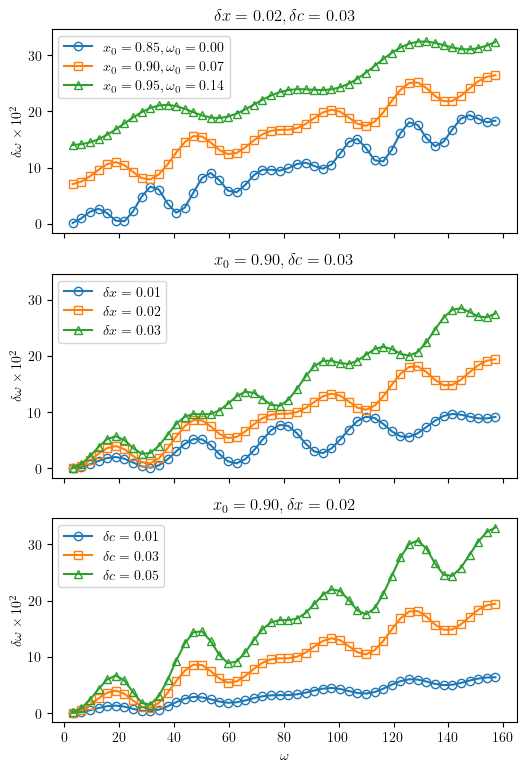

In [295]:
%matplotlib inline
fig, axes = plt.subplots(3, figsize=(6, 9), sharex=True, sharey=True)

loc0, width0, delta_sound0 = 0.9, 0.02, 0.03

locs = [0.85, loc0, 0.95]
widths = [0.01, width0, 0.03]
delta_sounds = [0.01, delta_sound0, 0.05]

offsets = np.array([0.0, 0.07, 0.14])

markers = ['o', 's', '^']
fac = 2
latex_fac = f"\\times {'10' if fac == 1 else f'10^{fac}'}" if fac != 0 else ""

ax = axes[0]
for loc, offset, marker in zip(locs, offsets, markers):
    ax = plot_omega(loc, width0, delta_sound0, ax=ax, offset=offset, fac=fac,
                    label=rf'$x_0={loc:.2f}, \omega_0 = {offset:.2f}$', 
                    marker=marker, markerfacecolor='none')

ax.set_ylabel(rf"$\delta\omega {latex_fac}$")
ax.set_title(rf'$\delta x = {width0:.2f}, \delta c = {delta_sound0:.2f}$')
ax.legend(loc='upper left')

ax = axes[1]
for width, offset, marker in zip(widths, offsets, markers):
    ax = plot_omega(loc0, width, delta_sound0, ax=ax, fac=fac,
                    label=rf'$\delta x={width:.2f}$', 
                    marker=marker, markerfacecolor='none')

ax.set_ylabel(rf"$\delta\omega {latex_fac}$")
ax.set_title(rf'$x_0 = {loc0:.2f}, \delta c = {delta_sound0:.2f}$')
ax.legend(loc='upper left')

ax = axes[2]
for delta_sound, offset, marker in zip(delta_sounds, offsets, markers):
    ax = plot_omega(loc0, width0, delta_sound, ax=ax, fac=fac,
                    label=rf'$\delta c={delta_sound:.2f}$', 
                    marker=marker, markerfacecolor='none')

ax.set_xlabel(r"$\omega$")
ax.set_ylabel(rf"$\delta\omega {latex_fac}$")
ax.set_title(rf'$x_0 = {loc0:.2f}, \delta x = {width0:.2f}$')
ax.legend(loc='upper left')

fig.savefig("../figures/glitch-1d-example-results.pdf", dpi=300, format="pdf", bbox_inches='tight')

In [296]:
eps_numpy = sympy.lambdify(
    (omega, c, dc, x0, dx, L),
    phase_sol[epsilon].subs(euler_trig).subs(sol).subs(wavenum_mapping),
    "numpy",
)

In [297]:
def plot_eps(loc, width, delta_sound, ax=None, offset=0.0, fac=0, **kwargs):
    omega_sol = find_omega(loc, width, delta_sound)
    args = (sound_speed, delta_sound, loc, min(width, length-loc), length)
    eps = eps_numpy(omega_sol, *args)
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(omega_sol, eps*10**fac, **kwargs)
    return ax

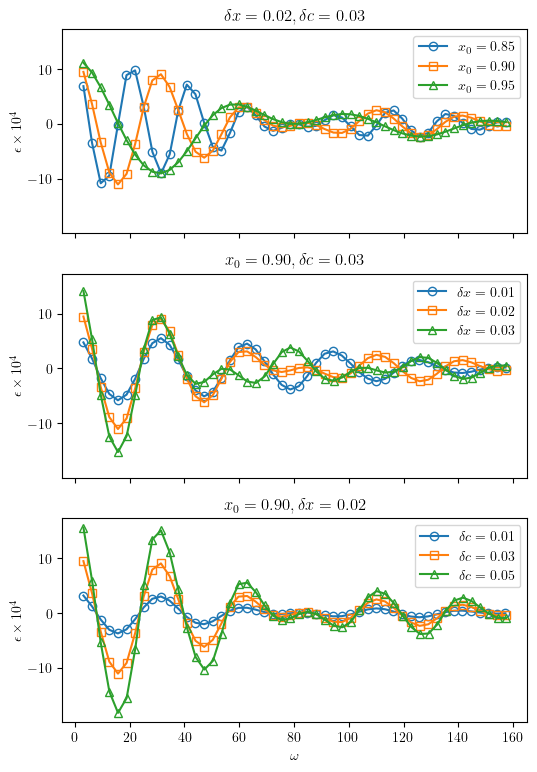

In [298]:
%matplotlib inline
fig, axes = plt.subplots(3, figsize=(6, 9), sharex=True, sharey=True)

loc0, width0, delta_sound0 = 0.9, 0.02, 0.03

locs = [0.85, loc0, 0.95]
widths = [0.01, width0, 0.03]
delta_sounds = [0.01, delta_sound0, 0.05]
markers = ['o', 's', '^']
fac = 4
latex_fac = f"\\times {'10' if fac == 1 else f'10^{fac}'}" if fac != 0 else ""

ax = axes[0]
for loc, marker in zip(locs, markers):
    ax = plot_eps(loc, width0, delta_sound0, ax=ax, fac=fac,
                    label=rf'$x_0={loc:.2f}$', 
                    marker=marker, markerfacecolor='none')

ax.set_ylabel(rf"$\epsilon {latex_fac}$")
ax.set_title(rf'$\delta x = {width0:.2f}, \delta c = {delta_sound0:.2f}$')
ax.legend(loc='upper right')

ax = axes[1]
for width, marker in zip(widths, markers):
    ax = plot_eps(loc0, width, delta_sound0, ax=ax, fac=fac,
                    label=rf'$\delta x={width:.2f}$', 
                    marker=marker, markerfacecolor='none')

ax.set_ylabel(rf"$\epsilon {latex_fac}$")
ax.set_title(rf'$x_0 = {loc0:.2f}, \delta c = {delta_sound0:.2f}$')
ax.legend(loc='upper right')

ax = axes[2]
for delta_sound, marker in zip(delta_sounds, markers):
    ax = plot_eps(loc0, width0, delta_sound, ax=ax, fac=fac,
                    label=rf'$\delta c={delta_sound:.2f}$', 
                    marker=marker, markerfacecolor='none')

ax.set_xlabel(r"$\omega$")
ax.set_ylabel(rf"$\epsilon {latex_fac}$")
ax.set_title(rf'$x_0 = {loc0:.2f}, \delta x = {width0:.2f}$')
ax.legend(loc='upper right')

fig.savefig("../figures/glitch-1d-example-phase.pdf", dpi=300, format="pdf", bbox_inches='tight')

In [299]:
plt.rc('text', usetex=False)

## Revisit homogenous case

In [67]:
psi = A * exp(i*(omega*t - k*x)) + B * exp(i*(omega*t + k*x))

In [68]:
bcs = [
    psi.subs(x, 0),
#     psi.diff(x).subs(x, 0)
]

psi_sol = sympy.solve(bcs, coeff)
psi_sol

{A: -B}

In [69]:
psi_total = psi.subs(B, -A)# - psi.subs(B, -A).subs(k, -k)

In [75]:
psi_real = sympy.re(psi_total.subs(A, r[A]/2 * exp(i * phi[A]))).factor().rewrite(cos).trigsimp()
psi_real

r_A*sin(k*x)*sin(omega*t + phi_A)

## Modelling the glitch

In [300]:
from scipy.optimize import curve_fit

In [484]:
def glitch_model(omega, a, b, delta_tau, tau_0):
    return a*omega - b * np.sin(2*delta_tau*omega) * np.cos(2*tau_0*omega)

In [485]:
# n = np.arange(1, 101)
# omega0_new = sound_speed * n * np.pi / length  # uniform medium case

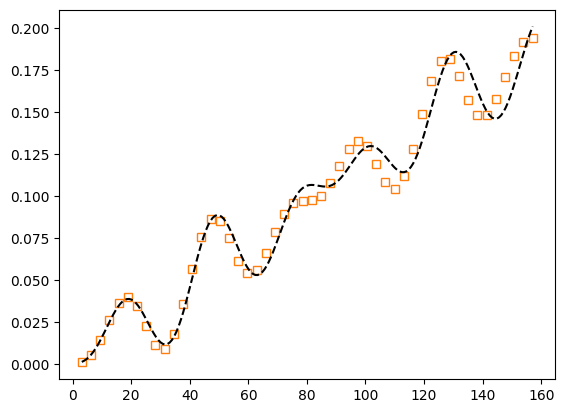

In [486]:
omega_test = np.linspace(omega0.min(), omega0.max(), 201)
p0 = [1.2e-3, 3e-2, np.pi/180, np.pi/18/1.8]#-1.36]
glitch_est = glitch_model(omega_test, *p0)

fig, ax = plt.subplots()

ax = plot_omega(loc0, width0, delta_sound0, omega0=omega0, color='C1', marker='s', markerfacecolor='none', linestyle='none', ax=ax)
ax.plot(omega_test, glitch_est, color='k', linestyle='--')

In [487]:
omega_obs = find_omega(loc0, width0, delta_sound0, omega0=omega0)
domega_obs = omega_obs - omega0

In [489]:
# p0 = (0.0, 6e-4, 3e-2, np.pi/180/2, np.pi/18/2, -1.36)
popt, pcov = curve_fit(glitch_model, omega0, domega_obs, p0=p0,
          bounds=([0.0, 0.0, 0.0, 0.0],# -np.pi],
                  [np.inf, np.inf, np.inf, np.inf]))#, np.pi]))

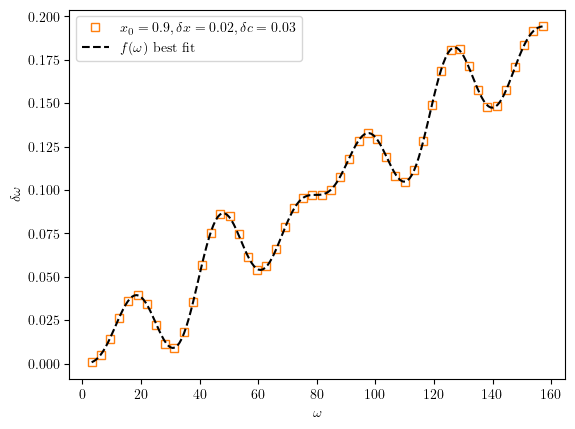

In [490]:
glitch_fit = glitch_model(omega_test, *popt)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots()

ax = plot_omega(loc0, width0, delta_sound0, omega0=omega0,
                color='C1', marker='s', markerfacecolor='none',  linestyle='none', ax=ax,
                label=rf'$x_0 = {loc0:.1f}, \delta x = {width0:.2f}, \delta c = {delta_sound0:.2f}$')
ax.plot(omega_test, glitch_fit, color='k', linestyle='--', label='$f(\omega)$ best fit')

ax.set_xlabel(r"$\omega$")
ax.set_ylabel(rf"$\delta\omega$")
ax.legend()

fig.savefig("../figures/glitch-1d-fit.pdf", dpi=300, format="pdf", bbox_inches='tight')

In [491]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')

In [494]:
popt[-1]*2

0.1990331917667021

In [495]:
popt[-2]*2

0.038850726476839945

In [519]:
popt[0]

0.001201783258816724

In [524]:
(2*popt[-2]*0.03)

0.0011655217943051983

In [497]:
popt[1]

0.03047401484730965

It seems popt[0] is 2 * delta_tau * delta_c / L (div by L cos of dimensions)

It appears popt[1] is delta_c / L (div by L cos of dimensions)

Let's put this too the test. Should see as delta_c and delta_x get large then the approximation that c = 1 everywhere gets worse.

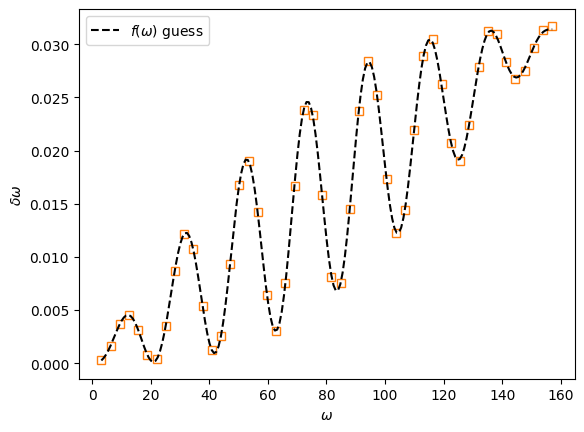

In [533]:
idx = 0
p0 = [2*widths[idx]*delta_sounds[idx]/length, delta_sounds[idx]/length, widths[idx], length - locs[idx]]
glitch_test = glitch_model(omega_test, *p0)

fig, ax = plt.subplots()

ax = plot_omega(locs[idx], widths[idx], delta_sounds[idx], omega0=omega0,
                color='C1', marker='s', markerfacecolor='none',  linestyle='none', ax=ax)
ax.plot(omega_test, glitch_test, color='k', linestyle='--', label='$f(\omega)$ guess')

ax.set_xlabel(r"$\omega$")
ax.set_ylabel(rf"$\delta\omega$")
ax.legend()

In [334]:
perr = np.sqrt(np.diag(pcov))

In [338]:
perr[-2]

6.668862078299629e-05

In [473]:
popt[0]

0.0012017886444330307

In [476]:
popt[-1]

-1.5683192163626756

In [552]:
length/2 - abs(loc0 - length/2)

0.09999999999999998

In [553]:
length/2 - abs(0.1 - length/2)

0.09999999999999998

In [557]:
(L/2 - sympy.Abs(x0 - L/2)).simplify()

L/2 - Abs(L - 2*x_0)/2

In [562]:
(L/2 - sympy.Abs(x0 - L/2)).expand()

L/2 - Abs(L/2 - x_0)